In [14]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))  # similar-expressions/
sys.path.insert(0, project_root)

# Reload modules
from importlib import reload
from src.model import decoder
from src.model import encoder
from src.utils import dataset, config, dev, dataset_dev, parsing, grammar
reload(decoder); reload(encoder); reload(dataset); reload(config); reload(dev); reload(dataset_dev); reload(parsing); reload(grammar); reload(grammar)

<module 'src.utils.grammar' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/utils/grammar.py'>

In [16]:
import torch
import numpy as np
import sympy as sp
import pandas as pd

from src.utils.dataset_dev import load_wandb_model, dataloader_from_wandb_cfg, data_from_loader
from src.utils.dataset import create_value_transform
from src.utils.dev import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from omegaconf import OmegaConf

# Load model and dataset
model, cfg = load_wandb_model(run='e51hcsb9', name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../train/config.yaml')
train_loader, test_loader, info = dataloader_from_wandb_cfg(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "e51hcsb9".
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | encoder | Encoder | 8.9 M  | eval
1 | decoder | Decoder | 8.6 M  | eval
-------------------------------------------
17.5 M    Trainable params
0         Non-trainable params
17.5 M    Total params
70.150    Total estimated model params size (MB)
0         Modules in train mode
78        Modules in eval mode


KeyboardInterrupt: 

## Latent space distribution (+ samples for later use)

In [12]:
def encode_and_sample_dataset(model, data_loader, cfg, batch_size=2**15, max_data_len=None, calc_var_stats=False):
    if max_data_len is not None:
        assert batch_size <= max_data_len, 'Batch size must be less than max_data_len'
        num_samples = min(len(data_loader.dataset), max_data_len)
    else:
        num_samples = len(data_loader.dataset)

    print(f'Number of samples: {len(data_loader.dataset)} (dataloader), {num_samples} (encoded)')
    z_size = cfg.model.z_size
    
    mu = np.empty([num_samples, z_size])
    z = np.empty([num_samples, z_size])

    if calc_var_stats:
        mean_of_var = np.empty(num_samples)
        std_of_var = np.empty(num_samples)
    else:
        mean_of_var, std_of_var = None, None
    
    for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=batch_size, max_length=max_data_len)):
        mean, ln_var = model.encoder(x)
        
        start_idx, end_idx = i * batch_size, (i + 1) * batch_size

        mu[start_idx:end_idx, :] = mean.detach().numpy()
        z[start_idx:end_idx, :] = model.sample(mean, ln_var).detach().numpy()

        if calc_var_stats:
            var = ln_var.exp() * cfg.training.sampling.eps**2  # Effective var
            mean_of_var[start_idx:end_idx] = var.mean(dim=1).detach().numpy()
            std_of_var[start_idx:end_idx] = var.std(dim=1).detach().numpy()
    
    return mu, z, mean_of_var, std_of_var

mu_train, z_train, mean_of_var_train, std_of_var_train = encode_and_sample_dataset(model, train_loader, cfg, calc_var_stats=False, max_data_len=2**16)
mu_test, z_test, mean_of_var_test, std_of_var_test = encode_and_sample_dataset(model, test_loader, cfg, calc_var_stats=False, max_data_len=2**16)

Number of samples: 14456801 (dataloader), 65536 (encoded)
Number of samples: 1606311 (dataloader), 65536 (encoded)


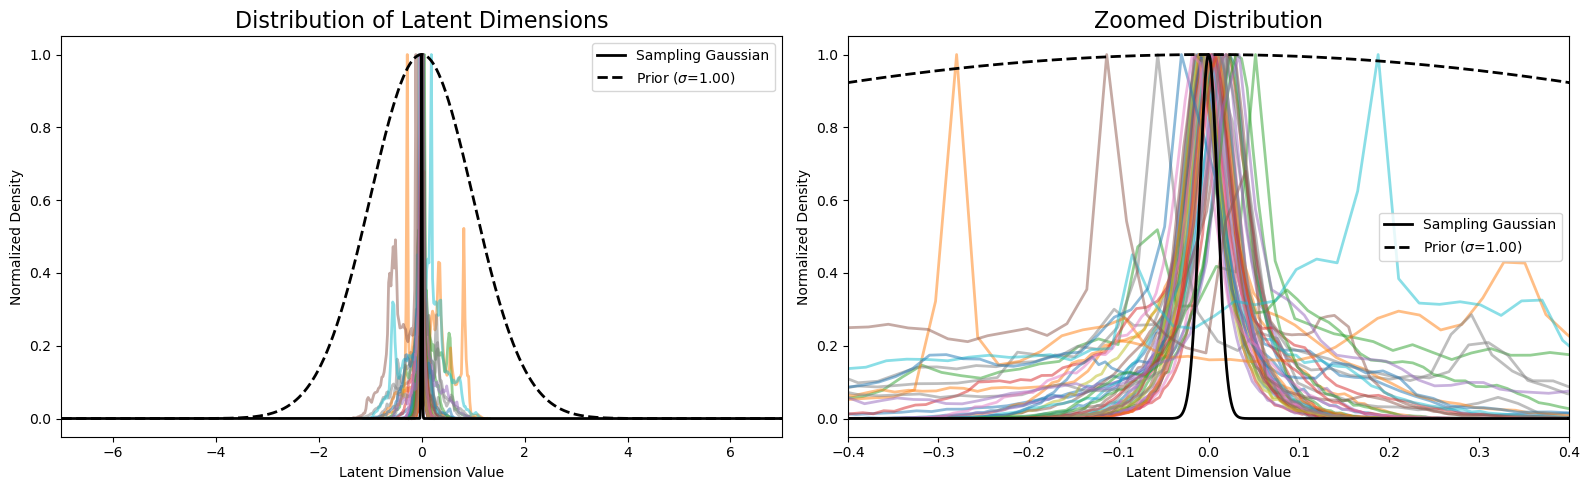

In [13]:
# plot_var_distributions(mean_of_var_train, mean_of_var_test, std_of_var_train, std_of_var_test)
plot_latent_distribution(mu_train, cfg)

## Examine neighbourhood in latent space of training samples 
Encode expression into latent space, sample from neighbourhood and then decode value. Done for 16 different expressions

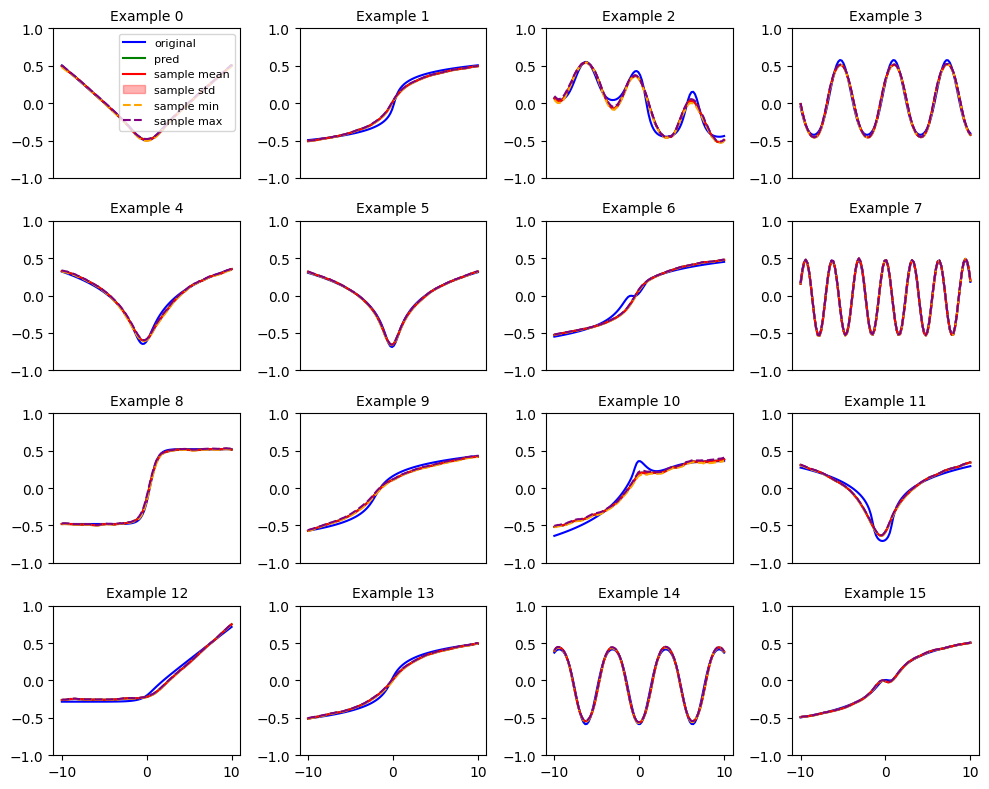

In [36]:
# Sampling with decoder -> eval
from src.utils.dev import calc_and_plot_samples_grid

# model.sampling_eps = 1e-1

start_idx = 0
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='value', val_x=val_x, value_transform=value_transform, var_multiplier=1, use_const_var=False)

Encode into latent space, sample from neighbourhood, decode expression and evaluate it.

Evaluating neighbourhood, might take a while.:  18%|█▊        | 18/100 [00:00<00:01, 55.24it/s]

Evaluating neighbourhood, might take a while.:  37%|███▋      | 37/100 [00:00<00:01, 57.52it/s]

Evaluating neighbourhood, might take a while.:  92%|█████████▏| 92/100 [00:01<00:00, 63.33it/s]/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/debug_util.py:421: RuntimeWarning: overflow encountered in cast
  res = res_raw.astype(np.float32)
Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:01<00:00, 58.76it/s]
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:01<00:00, 93.70it/s]
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in reduce


Evaluating neighbourhood, might take a while.:  94%|█████████▍| 94/100 [00:01<00:00, 70.55it/s]

Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:01<00:00, 71.04it/s]
/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/numpy/_core/_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
Evaluating neighbourhood, might take a while.:   7%|▋         | 7/100 [00:00<00:01, 68.03it/s]

Evaluating neighbourhood, might take a while.:  42%|████▏     | 42/100 [00:00<00:00, 74.01it/s] 

Evaluating neighbourhood, might take a while.:  77%|███████▋  | 77/100 [00:01<00:00, 42.61it/s]

Evaluating neighbourhood, might take a while.:  10%|█         | 10/100 [00:00<00:05, 17.62it/s]

Evaluating neighbourhood, might take a while.:  94%|█████████▍| 94/100 [00:01<00:00, 69.08it/s]

Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:02<00:00, 47.25it/s]


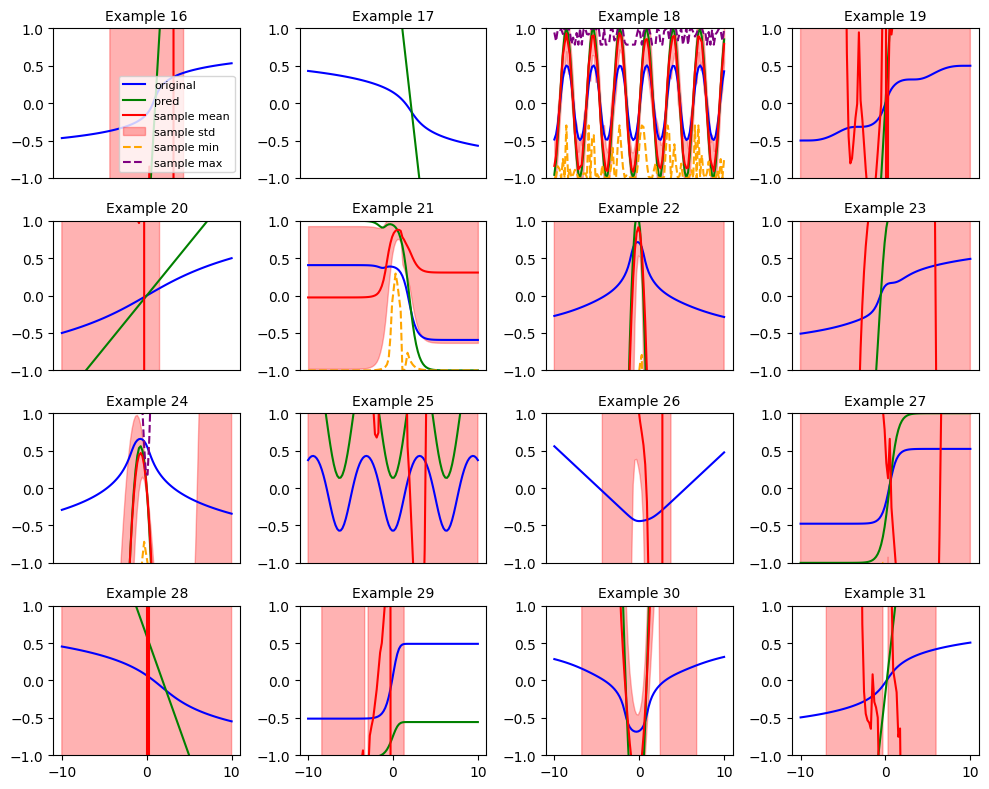

In [6]:
# Sampling with decoder -> eval
from src.utils.dev import calc_and_plot_samples_grid

# model.sampling_eps = 1e-1

start_idx = 16
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='syntax', val_x=val_x, value_transform=value_transform, var_multiplier=10, use_const_var=False)

## Mean distance

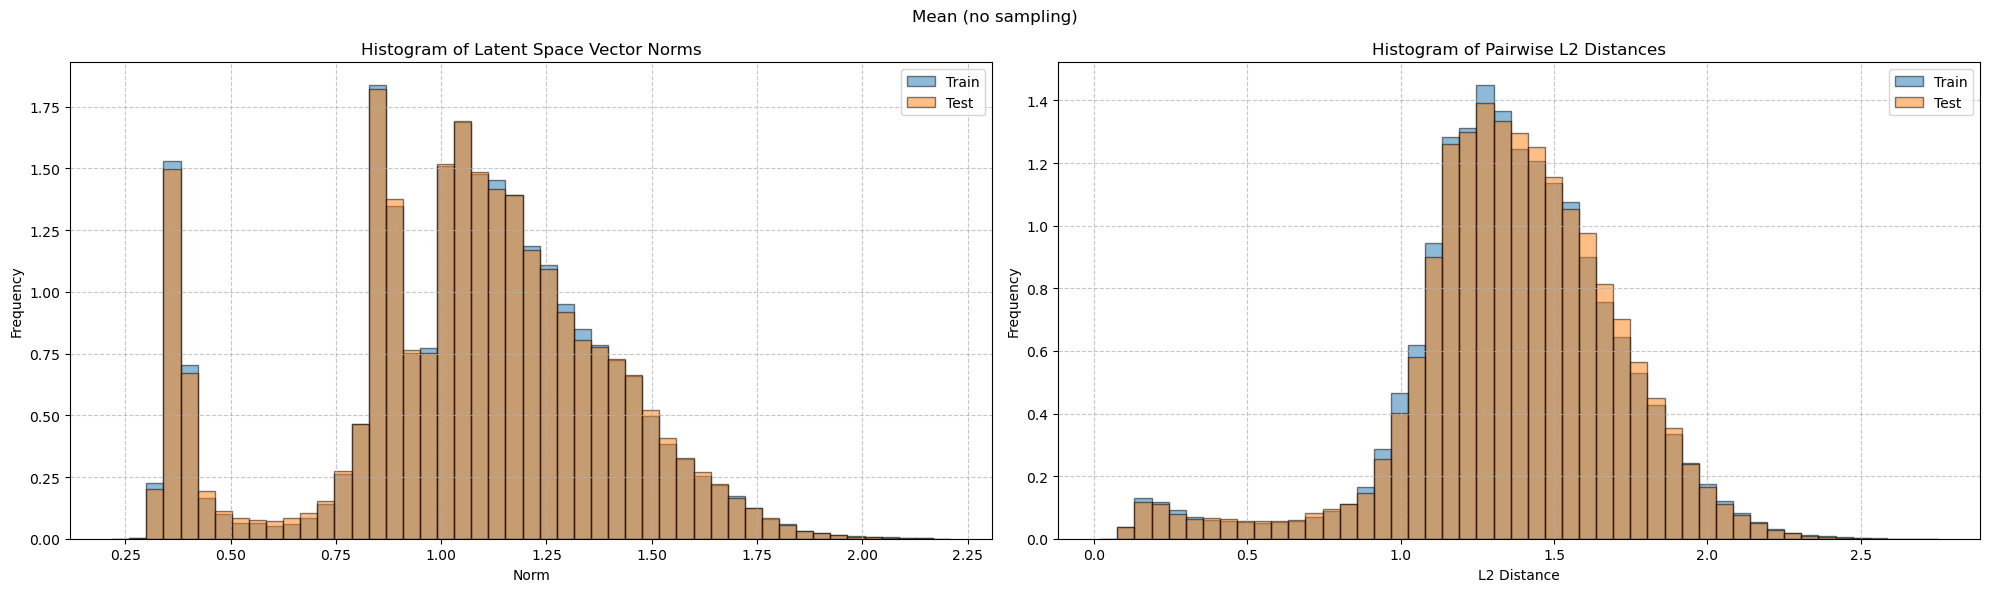

In [42]:
from src.utils.dev import plot_latent_distances

plot_latent_distances(mu_train, mu_test, 'Mean (no sampling)')

In [57]:
a = mu_train

sample_size = 10000
sampled_train = a[np.random.choice(a.shape[0], sample_size, replace=False)]
pairwise_distances_train = np.sum(sampled_train[:, np.newaxis] * sampled_train, axis=2)
l2_distances_train = pairwise_distances_train[np.triu_indices(sample_size, k=1)]

plt.hist(l2_distances_train, bins=50)

## Interpolation study

In [49]:
## Decoding only (for models with no expression decoder)
import grammar
reload(grammar)
import src.utils.dev as dev
reload(dev)
import parsing
reload(parsing)
from src.utils.dev import plot_value_interpolation, slerp
from src.utils.parsing import logits_to_infix, eval_from_logits

# Parameters
i, j = 1, 8
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
logits_interp = model.decoder(torch.tensor(z_interp.astype(np.float32)))
    
values_interp = torch.empty(size=(logits_interp.shape[0], val_x.shape[0]))
for idx in range(0, logits_interp.shape[0]):
    res = eval_from_logits(logits_interp[idx, ...], val_x.squeeze())
    try:
        res = res.astype(np.float32)
        values_interp[idx, ...] = value_transform(torch.tensor(res).unsqueeze(0)).squeeze()
    except TypeError:
        print(f'Warning: Failed to decode logits {idx}')
        values_interp[idx, ...] = torch.zeros_like(res, dtype=torch.float32)


fig, ax1 = plt.subplots(figsize=(10, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Value Decoding')

Distance: 1.6006240039822055


AttributeError: 'float' object has no attribute 'astype'

In [33]:
eval_from_logits(logits_interp[22, ...], val_x.squeeze())

-7.345851049282202

Distance: 2.1248750466638655


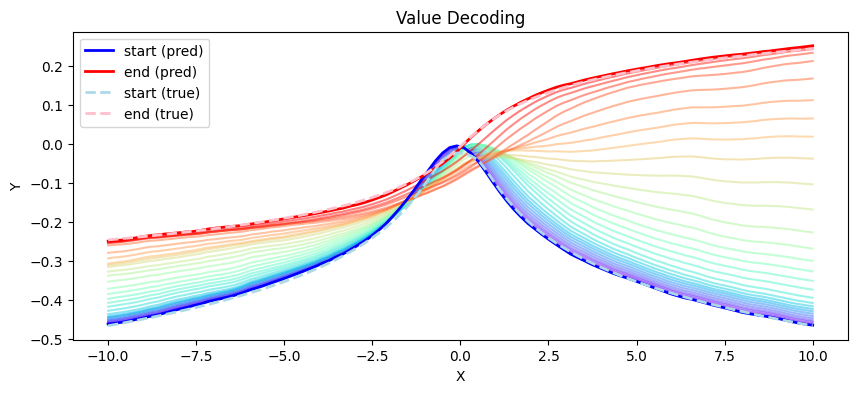

In [77]:
## Value decoding only (for models with no expression decoder)
import src.utils.dev as dev
reload(dev)
from src.utils.dev import plot_value_interpolation, slerp

# Parameters
i, j = 1, 5
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
values_interp = model.value_decoder(torch.tensor(z_interp.astype(np.float32)))


fig, ax1 = plt.subplots(figsize=(10, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Value Decoding')

In [31]:
reload(dev)
import grammar
reload(grammar)
import parsing
reload(parsing)
from src.utils.dev import plot_interpolation

Distance: 2.7642788130242777


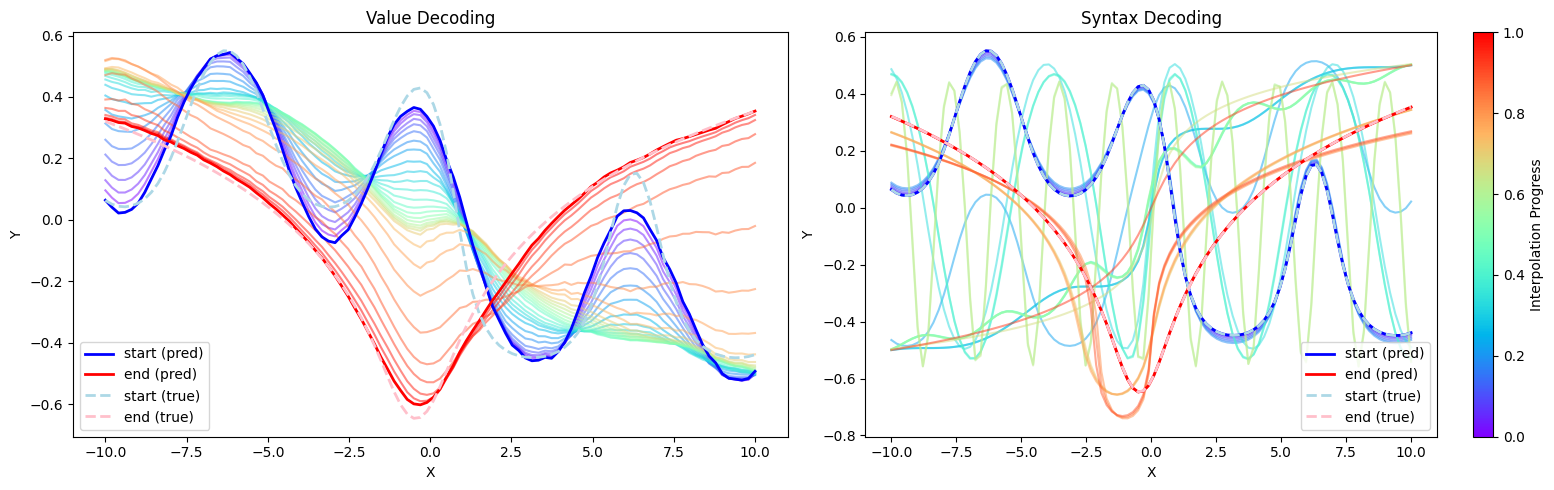

In [24]:
import src.utils.dev as dev
reload(dev)
from src.utils.dev import plot_interpolation

i, j = 2, 4
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()

plot_interpolation(model, val_x, z_start, z_end, start_true, end_true, value_transform, num_steps=30, interp_mode='slerp')

## Local vs global structuring (legacy)

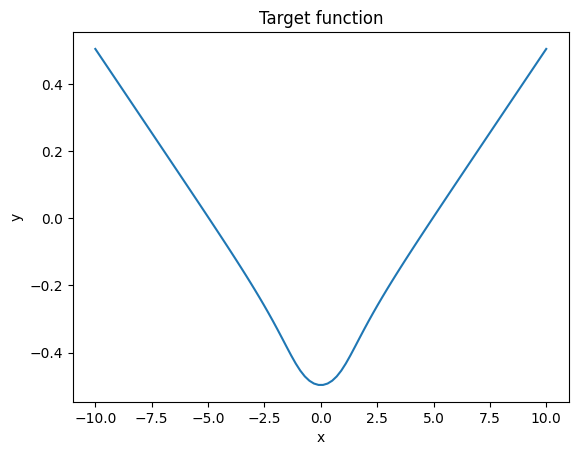

In [25]:
target_idx = 0
data_loader = train_loader  # FIXME: Only works with train_loader currently...
values = data_from_loader(data_loader, 'values', idx=target_idx)  

plt.plot(val_x.squeeze(), values.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [26]:
import seaborn as sns

N = 2**17
BATCH_SIZE = 2**15
use_u_only = True

z_slice = model.value_decoder.z_slice

values = data_from_loader(data_loader, 'values', max_length=N)
x = data_from_loader(data_loader, 'x', max_length=N)
z = torch.empty(N, model.cfg.model.z_size)
for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=BATCH_SIZE, max_length=N)):
    mean, ln_var = model.encoder(x)
    z[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = mean

target_values = values[target_idx, :]
target_z = z[target_idx, :]

dist_y = torch.mean((values - target_values)**2, dim=1)  # MSE

if not use_u_only:
    dist_z = torch.norm(z - target_z, dim=1)
else:
    dist_z = torch.norm(z[:, z_slice[0]:z_slice[1]] - target_z[z_slice[0]:z_slice[1]], dim=1)

mse_sorted = pd.Series(dist_y).sort_values()

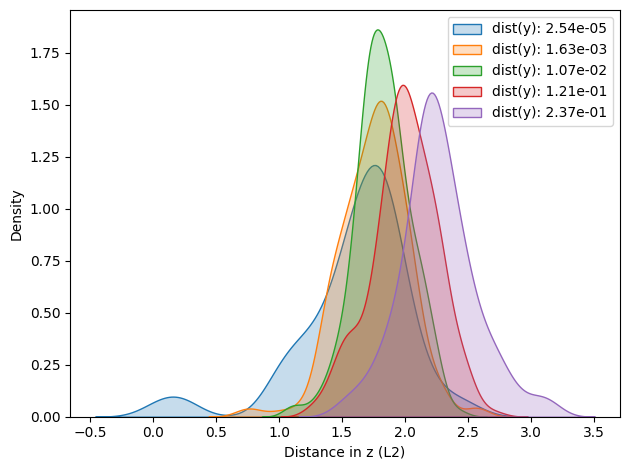

In [27]:
for i in [0, 3000, 10000, 20000, 80000]:
    idx = mse_sorted.index[i:i+200]
    sns.kdeplot(dist_z[idx], label=f'dist(y): {dist_y[idx].mean():.2e}', fill=True)
# plt.xlim(0, 2)
plt.legend()
plt.xlabel('Distance in z (L2)')
plt.tight_layout()
plt.show()


# # Create histogram version
# for i in [0, 3000, 10000, 20000, 80000]:
#     idx = mse_sorted.index[i:i+200]
#     plt.hist(dist_z[idx], bins=50, range=(0, dist_z.max().item()), alpha=0.5, label=f'dist(y): {dist_y[idx].mean():.2e}')
# plt.xlabel('Distance in z (L2)')
# plt.legend()
# plt.tight_layout()
# plt.show()


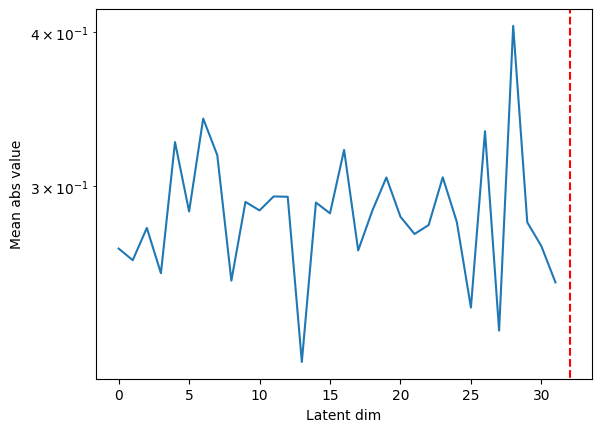

In [28]:
plt.plot(torch.mean(torch.abs(z), dim=0))
plt.yscale('log')
plt.xlabel('Latent dim')
plt.ylabel('Mean abs value')
plt.vlines(z_slice[1], 0, 1, color='r', linestyle='--') 
plt.show()

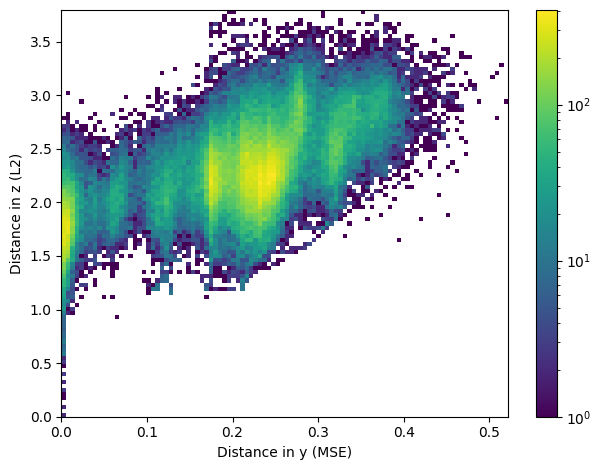

In [29]:
from matplotlib.colors import LogNorm

plt.hist2d(dist_y, dist_z, bins=[100, 100], norm=LogNorm())  # range=[(0, 1e-4), (0, 2)]
plt.colorbar()
plt.ylabel('Distance in z (L2)')
plt.xlabel('Distance in y (MSE)')
plt.tight_layout()
plt.show()

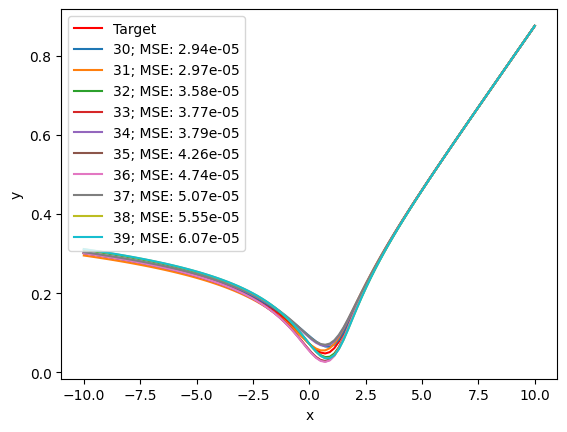

In [82]:
# Plot examples
i, n = int(3e1), 10
assert i < len(values), 'Index out of bounds'

plt.plot(val_x.squeeze(), target_values.squeeze().detach().numpy(), label='Target', color='r')
plt.plot(val_x.squeeze(), values[mse_sorted.index[i:i+n], :].detach().numpy().T, label=[f'{idx}; MSE: {mse_sorted.to_numpy()[idx]:.2e}' for idx in range(i, i+n)])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Property prediction (SNIP-inspired)

In [8]:
from src.utils.dev import calc_properties, plot_tsne_properties, plot_property_distributions, plot_original_vs_predicted_properties, plot_values_with_property
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt     

BATCH_SIZE = 2**15

properties = np.empty((len(train_loader.dataset), 4))
for i, x in enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE)):
    mean, upwardness, oscillations, non_convexity_ratio = calc_properties(x)
    oscillations = np.log(oscillations + 1)
    properties[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = np.array([mean, upwardness, oscillations, non_convexity_ratio]).T

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_15165/2422307526.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  oscillations = np.log(oscillations + 1)


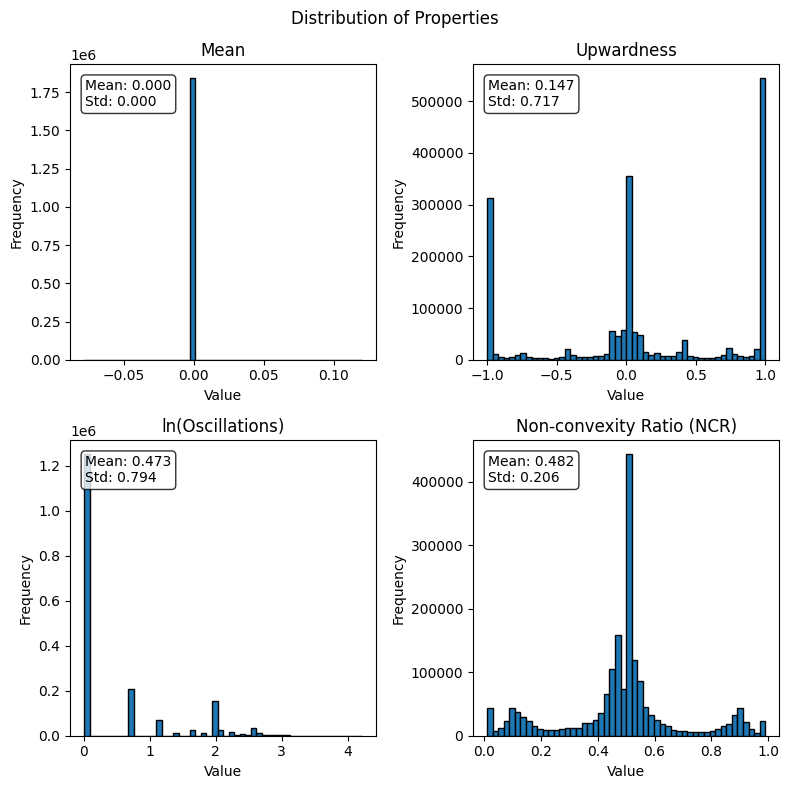

In [9]:
plot_property_distributions(properties)

In [10]:
n = 10000  # Number of samples to plot (tsne is slow!)
pca = PCA(n_components=6)
mu_train_pca = pca.fit_transform(mu_train[:n])
mu_train_2d = TSNE(n_components=2, random_state=42).fit_transform(mu_train_pca)

print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Cumulative explained variance ratio: 0.6501


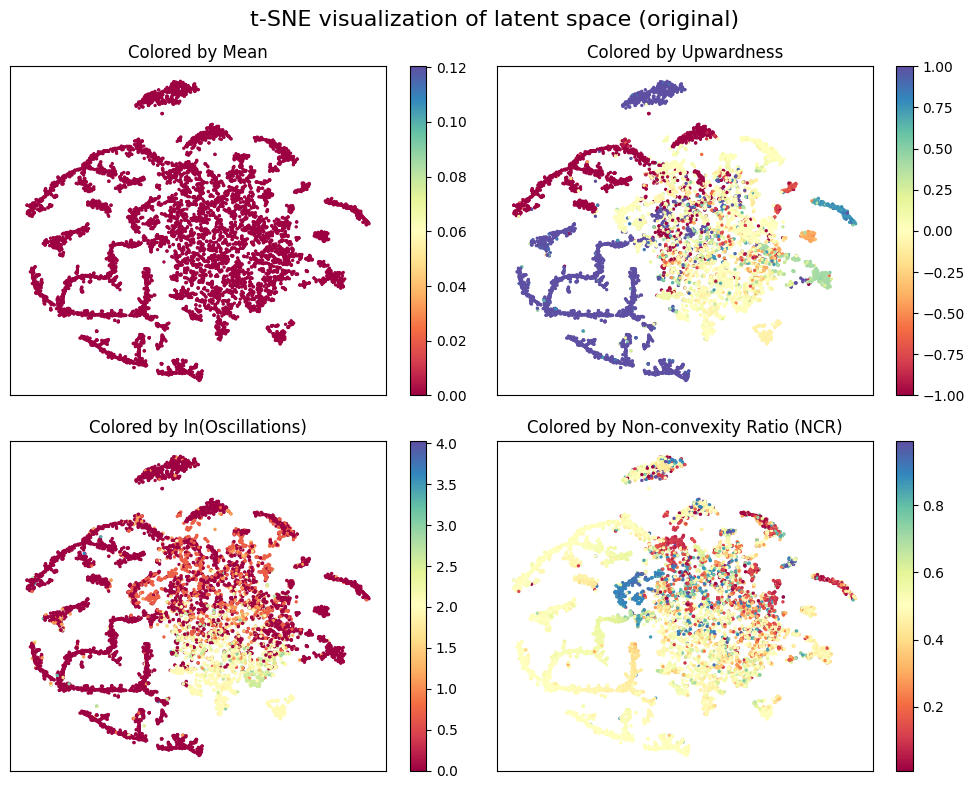

In [11]:
plot_tsne_properties(mu_train_2d, properties[:n], title='t-SNE visualization of latent space (original)')

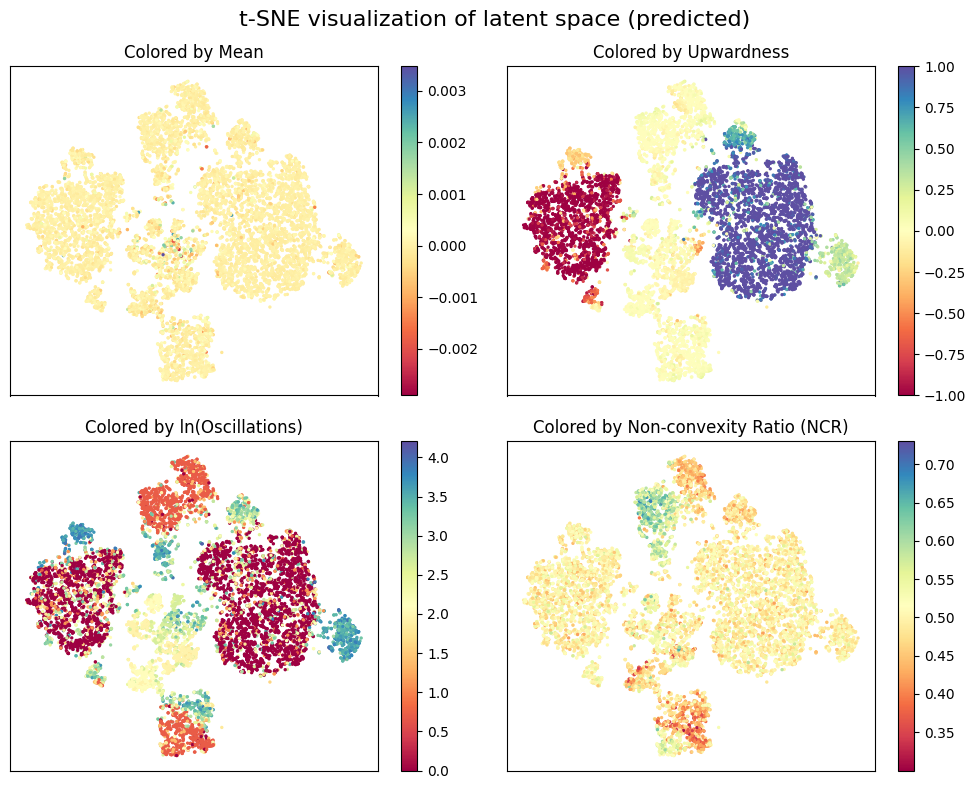

In [34]:
values_pred = model.value_decoder(torch.tensor(mu_train[:n]).float())
mean, upwardness, oscillations, non_convexity_ratio = calc_properties(values_pred)
properties_pred = np.array([mean, upwardness, torch.log(1+oscillations), non_convexity_ratio]).T

plot_tsne_properties(mu_train_2d, properties_pred[:n], title='t-SNE visualization of latent space (predicted)')

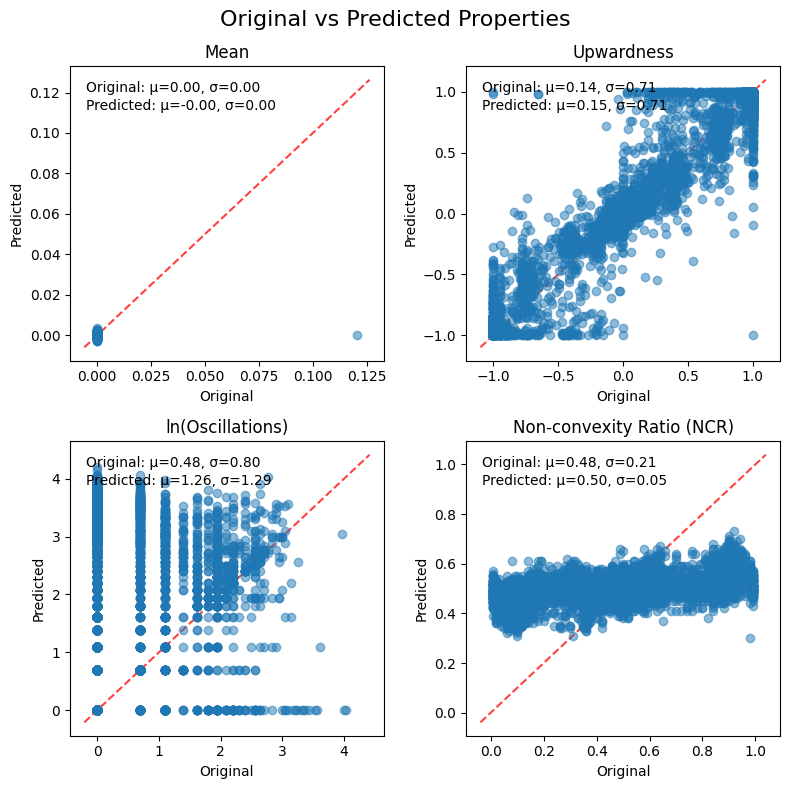

In [35]:
plot_original_vs_predicted_properties(properties[:n], properties_pred)

#### Properties on example

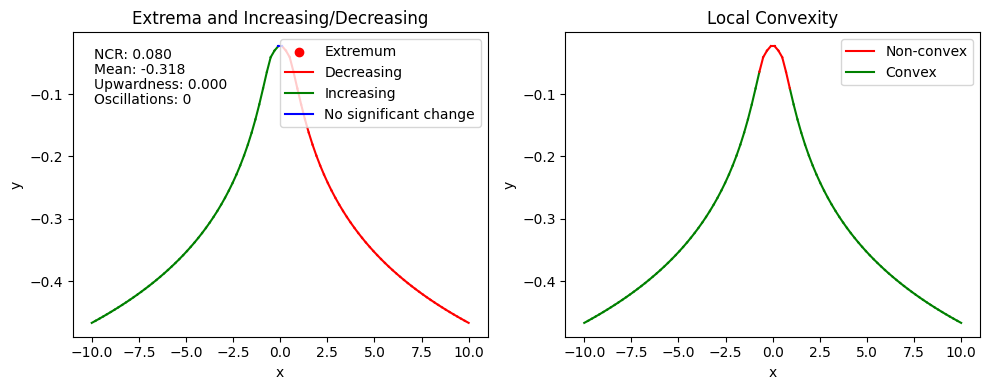

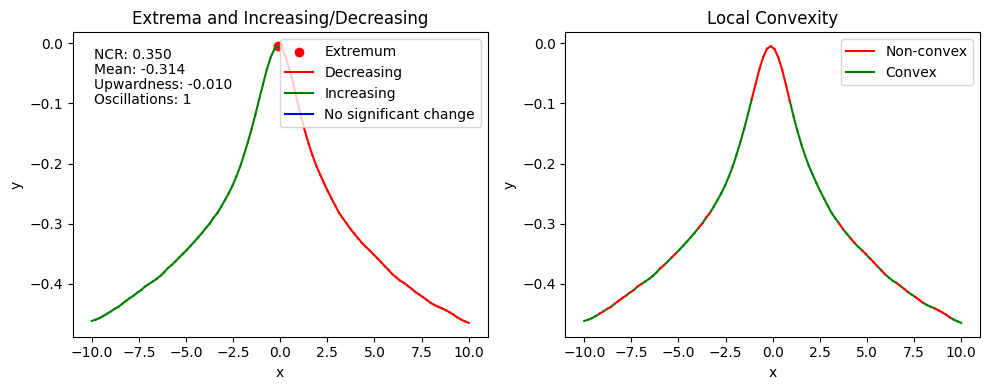

In [95]:
i = 1
y_values = data_from_loader(train_loader, 'values', idx=i)
values_pred = model.value_decoder(torch.tensor(mu_train[i]).unsqueeze(0).float())
plot_values_with_property(y_values)
plot_values_with_property(values_pred)